In [1]:
!cp /kaggle/input/tampered-only/casia -r /kaggle/working/

In [2]:
import os
os.mkdir('/kaggle/working/casia/final')

In [3]:
!cp /kaggle/input/addimage -r /kaggle/working/casia/final

In [4]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
#from skimage.morphology import label
from sklearn.model_selection import train_test_split
import cv2

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, UpSampling2D
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import Input, Dense, Concatenate, Add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image as image_utils


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [5]:
def rename_ext(root_dir = '/kaggle/working/casia', ext1 = '.png'):

  import os
  train_path = root_dir
  ext1 = ext1
  dirs = os.listdir(train_path)
  for dir in dirs:
    t_ids = os.listdir(os.path.join(train_path,dir)) 
    for names in t_ids:
      ids,ext = os.path.splitext(names)
      os.rename(os.path.join(train_path,dir,names),os.path.join(train_path,dir,ids+ext1))
        
rename_ext()        

In [6]:
#### 2 DIMENSIONS ####

def get_data(path,train = True):
  ids = os.listdir(path + "/final/addimage.png/")
  X = np.zeros((len(ids),256,256, 3), dtype=np.float32)
  if train:
    y = np.zeros((len(ids),256,256,1), dtype=np.float32)
  print('Getting and resizing images ... ')
  for n, id_ in tqdm_notebook(enumerate(ids),total = len(ids)):
    # Load Images
    orig_img = image_utils.image_utils.load_img(path+'/final/addimage.png/'+id_, grayscale=True)
    orig_img = image_utils.image_utils.img_to_array(orig_img)
    x_orig_img = resize(orig_img, (256,256,3), mode='constant', preserve_range=True) 
    x_orig_img = x_orig_img.squeeze() 
    if train:
      mask = image_utils.image_utils.img_to_array(image_utils.image_utils.load_img(path + '/mask_images/' + id_[:-5]+'_gt.png', grayscale=True))
      mask = resize(mask, (256,256,1), mode='constant', preserve_range=True)    

    # Save Images 
    X[n,...] = x_orig_img/255 
    if train:
      y[n] = mask/255
  print("Done!")
  if train:
    return X, y 
  else :
    return X         

train_path = '/kaggle/working/casia'
X,y = get_data(train_path, train = True)    


Getting and resizing images ... 


/tmp/ipykernel_28/1631834065.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(ids),total = len(ids)):


  0%|          | 0/2004 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


Done!


In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=2020)


In [8]:
y_train.shape

(1503, 256, 256, 1)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation parameters
data_gen_args = dict(
    rotation_range=15,             # Random rotation within the range [0, 15] degrees
    width_shift_range=0.1,         # Random horizontal shift within the range [0, 0.1]
    height_shift_range=0.1,        # Random vertical shift within the range [0, 0.1]
    shear_range=0.2,               # Shear transformations with max shear of 20%
    zoom_range=0.2,                # Random zoom within the range [0.8, 1.2]
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'            # Fill mode for handling newly created pixels after transformations
)

# Create image and mask data generators with the specified data augmentation
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 2020
bs = 10

# Create generators for images and masks
image_generator = image_datagen.flow(X_train, seed=seed, batch_size=bs, shuffle=True)
mask_generator = mask_datagen.flow(y_train, seed=seed, batch_size=bs, shuffle=True)

# Zip the two generators to get a generator that provides augmented images and masks at the same time
train_generator = zip(image_generator, mask_generator)


In [10]:
!pip install -U -q segmentation-models
!pip install -q tensorflow==2.2.1
!pip install -q keras==2.5
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.14.0rc0)
ERROR: No matching distribution found for tensorflow==2.2.1
ERROR: Could not find a version that satisfies the requirement keras==2.5 (from versions: 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.5.0rc0, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0rc3, 2.6.0, 2.7.0rc0, 2.7.0rc2, 2.7.0, 2.8.0rc0, 2.8.

In [11]:
from segmentation_models import Unet
from tensorflow.keras.metrics import Precision, Recall

model_resnet = Unet('resnet101', input_shape=(256,256,3), classes=1, activation='sigmoid',encoder_weights='imagenet')


model_resnet.compile(optimizer=keras.optimizers.Adam(), loss="binary_crossentropy", metrics=['accuracy',Precision(),Recall()])

171164896/171164896 [==============================] - 3s 0us/step


In [15]:
from math import ceil

batch_size=10
num_training_samples=len(X_train)
num_validation_samples=len(X_valid)
# steps = ceil(len(X_train)//batch_size)
num_epochs=100


In [16]:
#### CALLBACKS ####

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
### MODELCHECKPOINT CALLBACK
save = ModelCheckpoint('/kaggle/working/unet_aug200-test3-batchnorm-cust-2d.h5', verbose=1, save_best_only=True, save_weights_only=True)

### REDUCES LR WHEN METRTIC IS NOT IMPROVING
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_delta =1e-4, min_lr=0.00001, mode='min')

### LEARNING RATE SCHEDULER
def scheduler(epoch):

  if epoch < 5:
     return 0.001
  else:
     return float(0.001 * tf.math.exp(0.01 * (10 - epoch)))
lr_schedule = LearningRateScheduler(scheduler) 

### EARLY STOPPING
early_stopping = EarlyStopping(patience=10, verbose=1)

In [17]:
# train model
results=model_resnet.fit(train_generator,steps_per_epoch=(num_training_samples // batch_size), epochs=num_epochs,
                            validation_data=[X_valid,y_valid],validation_steps=num_validation_samples//batch_size,
                         verbose=1,callbacks=[early_stop,reduce_lr,checkpoint])

Epoch 1/100
150/150 [==============================] - 44s 292ms/step - loss: 0.3066 - accuracy: 0.8888 - precision: 0.5527 - recall: 0.0392 - val_loss: 0.3348 - val_accuracy: 0.8892 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/100
150/150 [==============================] - 38s 256ms/step - loss: 0.3122 - accuracy: 0.8854 - precision: 0.5106 - recall: 0.0430 - lr: 0.0010
Epoch 3/100
150/150 [==============================] - 39s 257ms/step - loss: 0.3054 - accuracy: 0.8892 - precision: 0.5971 - recall: 0.0477 - lr: 0.0010
Epoch 4/100
150/150 [==============================] - 39s 261ms/step - loss: 0.3104 - accuracy: 0.8885 - precision: 0.6138 - recall: 0.0310 - lr: 0.0010
Epoch 5/100
150/150 [==============================] - 39s 263ms/step - loss: 0.3079 - accuracy: 0.8880 - precision: 0.5375 - recall: 0.0436 - lr: 0.0010
Epoch 6/100
150/150 [==============================] - 38s 256ms/step - loss: 0.2983 - accuracy: 0.8908 - precision: 0.5630 - recall: 0

In [20]:
preds_train = model_resnet.predict(X_train, verbose=1)
preds_val = model_resnet.predict(X_valid, verbose=1)



16/16 [==============================] - 4s 288ms/step


In [24]:
def plot_sample(X, y, preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0])
    ax[0].set_title('original-image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('tampering-actual')
 
    ax[2].imshow(preds[ix].squeeze())
    ax[2].set_title('tampering Predicted')

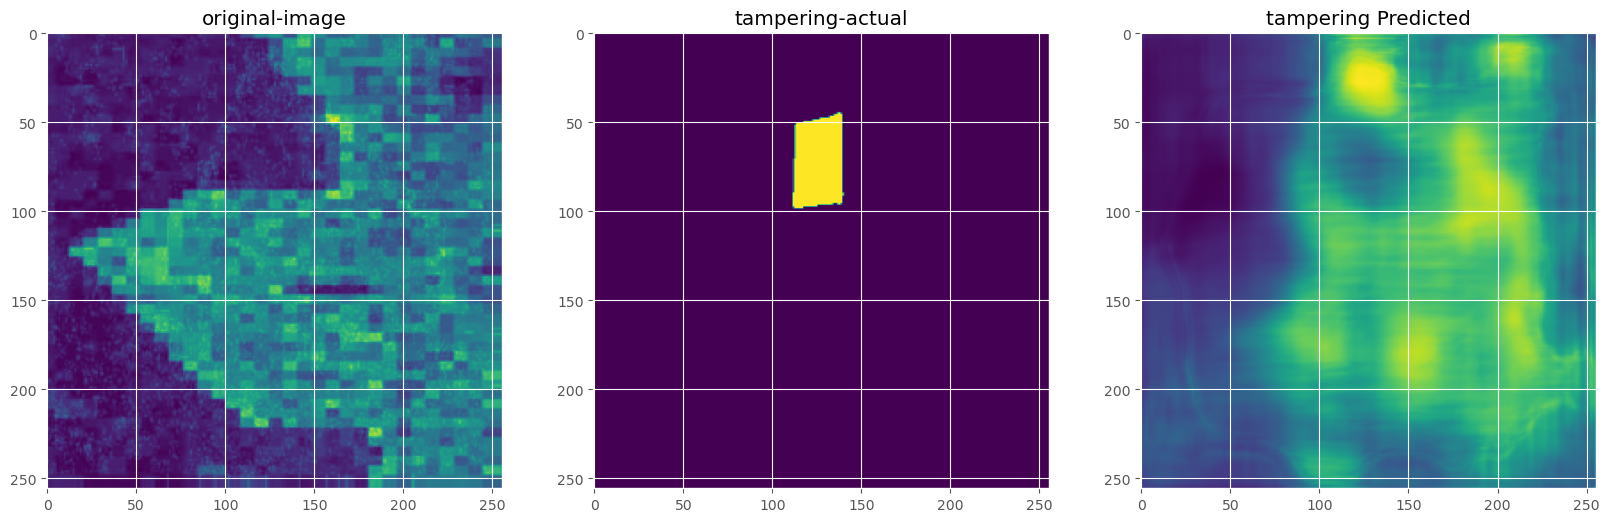

In [40]:
plot_sample(X_train, y_train, preds_train)